In [1]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
from amftrack.pipeline.development.high_mag_videos.plot_data import (
    save_raw_data,
    plot_summary,
)

# from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import segment_brightfield
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tifffile import imread
from tqdm import tqdm

%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from pathlib import Path
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-08-17 12:37:08.943435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 12:37:09.265245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:

In [17]:
def segment_brightfield(
    image, thresh=0.5e-6, frangi_range=np.arange(70, 170, 30), seg_thresh=11, binning=2
):
    frangi_range = frangi_range * 2 / binning
    smooth_im_blur = cv2.blur(-image, (11, 11))
    smooth_im = frangi(-smooth_im_blur, frangi_range)
    smooth_im = np.array(smooth_im * (255 / np.max(smooth_im)), dtype=np.uint8)
    seg_shape = smooth_im.shape

    #     for i in range(1, 100):
    #         _, segmented = cv2.threshold(smooth_im, i, 255, cv2.THRESH_BINARY)
    #         coverage = 100 * np.sum(1 * segmented.flatten()) / (255 * seg_shape[0] * seg_shape[1])
    #         if coverage < seg_thresh:
    #             break
    return smooth_im


def segment_fluo(
    image,
    thresh=0.5e-7,
    seg_thresh=4.5,
    k_size=40,
    magnif=50,
    binning=2,
    test_plot=False,
):
    k_size = [30, 5][magnif < 50]
    kernel = np.ones((k_size, k_size), np.uint8)
    kernel_2 = np.ones((10, 10), np.uint8)
    smooth_im = cv2.GaussianBlur(image, (5, 5), 0)
    #     smooth_im = cv2.morphologyEx(smooth_im, cv2.MORPH_TOPHAT, kernel)
    #     im_canny_smooth = cv2.GaussianBlur(im_canny, (5, 5), 0)
    smooth_im_close = cv2.morphologyEx(smooth_im, cv2.MORPH_OPEN, kernel)
    #     std_im = generic_filter(image, np.std, size=10)
    if magnif < 30:
        im_canny = cv2.Canny(smooth_im, 0, 20)
        smooth_im = cv2.morphologyEx(im_canny, cv2.MORPH_DILATE, kernel)

    #     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    #     retval, labels, centers = cv2.kmeans(k_data, [4, 2][magnif < 30], None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    #     centers = np.uint8(centers)
    #     labels = np.array(labels.T[0])
    #     centers = [center[0] for center in centers]
    #     segmented_data = np.array([centers[label] for label in labels])
    #     segmented_image = segmented_data.reshape((smooth_im.shape))
    #     segmented_image = np.uint8(segmented_image > np.min(centers))
    #     segmented = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel_2)

    #     skeletonized = skeletonize(segmented > thresh)

    #     if test_plot:
    #         fig, ax = plt.subplots(7, figsize=(9, 25))
    #         ax[0].imshow(im_canny)
    #         ax[0].set_title("Smooth")
    #         ax[1].imshow(std_im)
    #         ax[1].set_title("open")
    #         ax[2].imshow(smooth_im)
    #         ax[2].set_title("smooth_im")
    #         ax[3].imshow(segmented)
    #         ax[3].set_title("segmented")
    #         ax[4].imshow(skeletonized)
    #         ax[5].hist(smooth_im_close.flatten(), log=True, bins=50)
    #         ax[6].plot(smooth_im_close[1000])
    #         fig.tight_layout()

    #     skeleton = scipy.sparse.dok_matrix(skeletonized)
    #     nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
    #     nx_graph_pruned, pos = remove_spurs(nx_graph, pos, threshold=200)
    return smooth_im, smooth_im_close


vid_folder = Path("/gpfs/scratch1/shared/amftrackflow/videos/CocoTransport/")
plate = "20230810_Plate441"
vid_interest = "006"
# edge_interest = "edge (115, 104)"
img_address = vid_folder / plate / vid_interest
# img_address = vid_folder


# print(imgs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.62it/s]


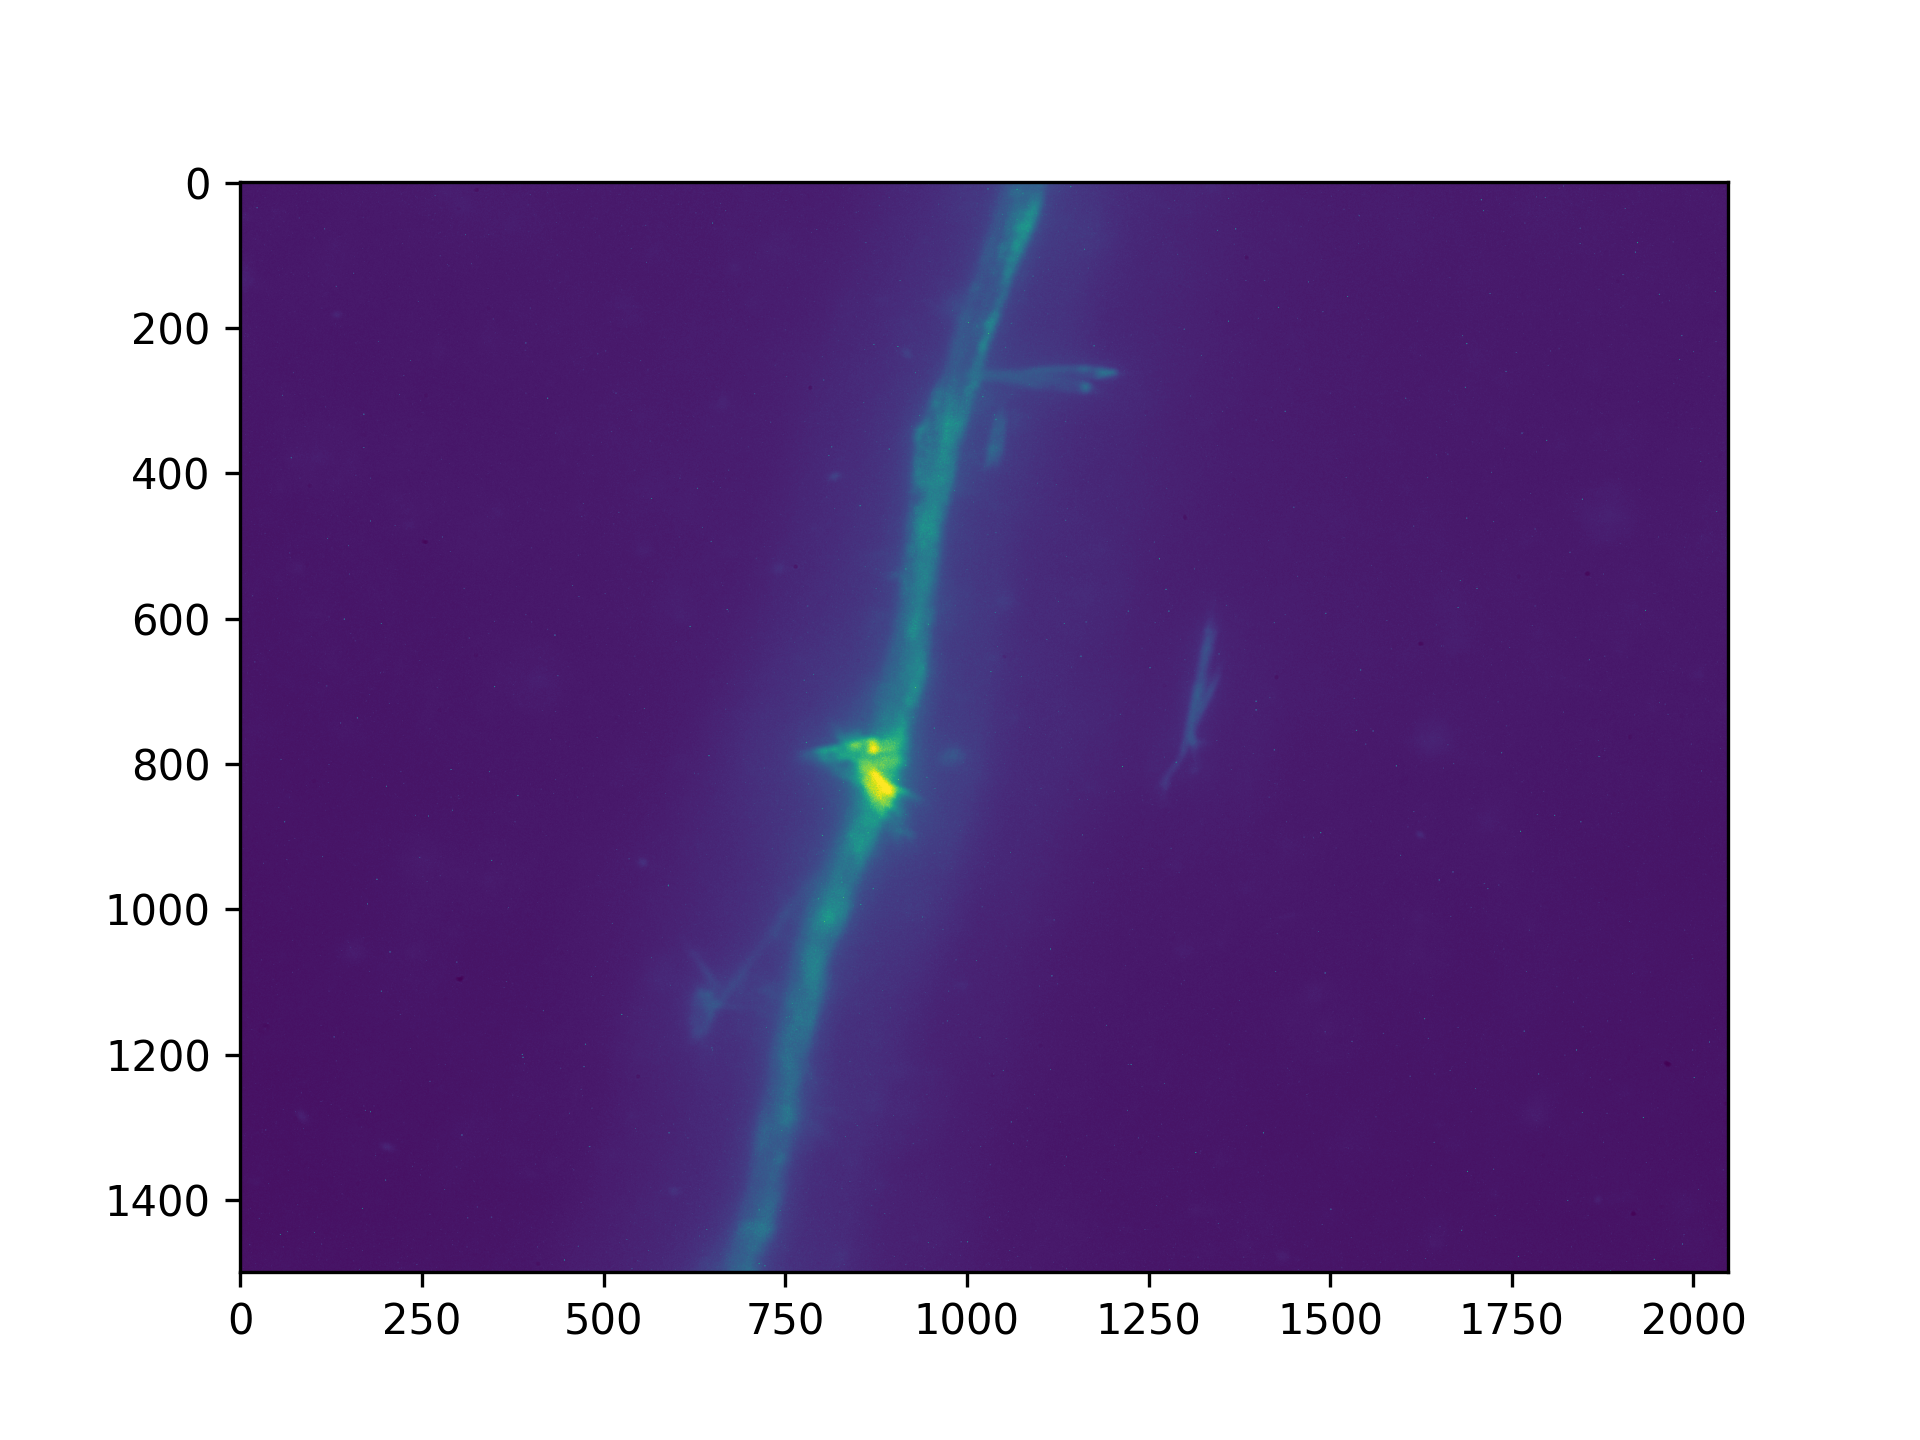

In [18]:
imgs = sorted([path for path in img_address.glob("*/*.ti*")])
frame_max = imread(imgs[0])
for address in tqdm(imgs):
    frame2 = imread(address)
    frame_max = np.maximum(frame_max, frame2)
img = frame_max


fig, ax = plt.subplots()
ax.imshow(img)

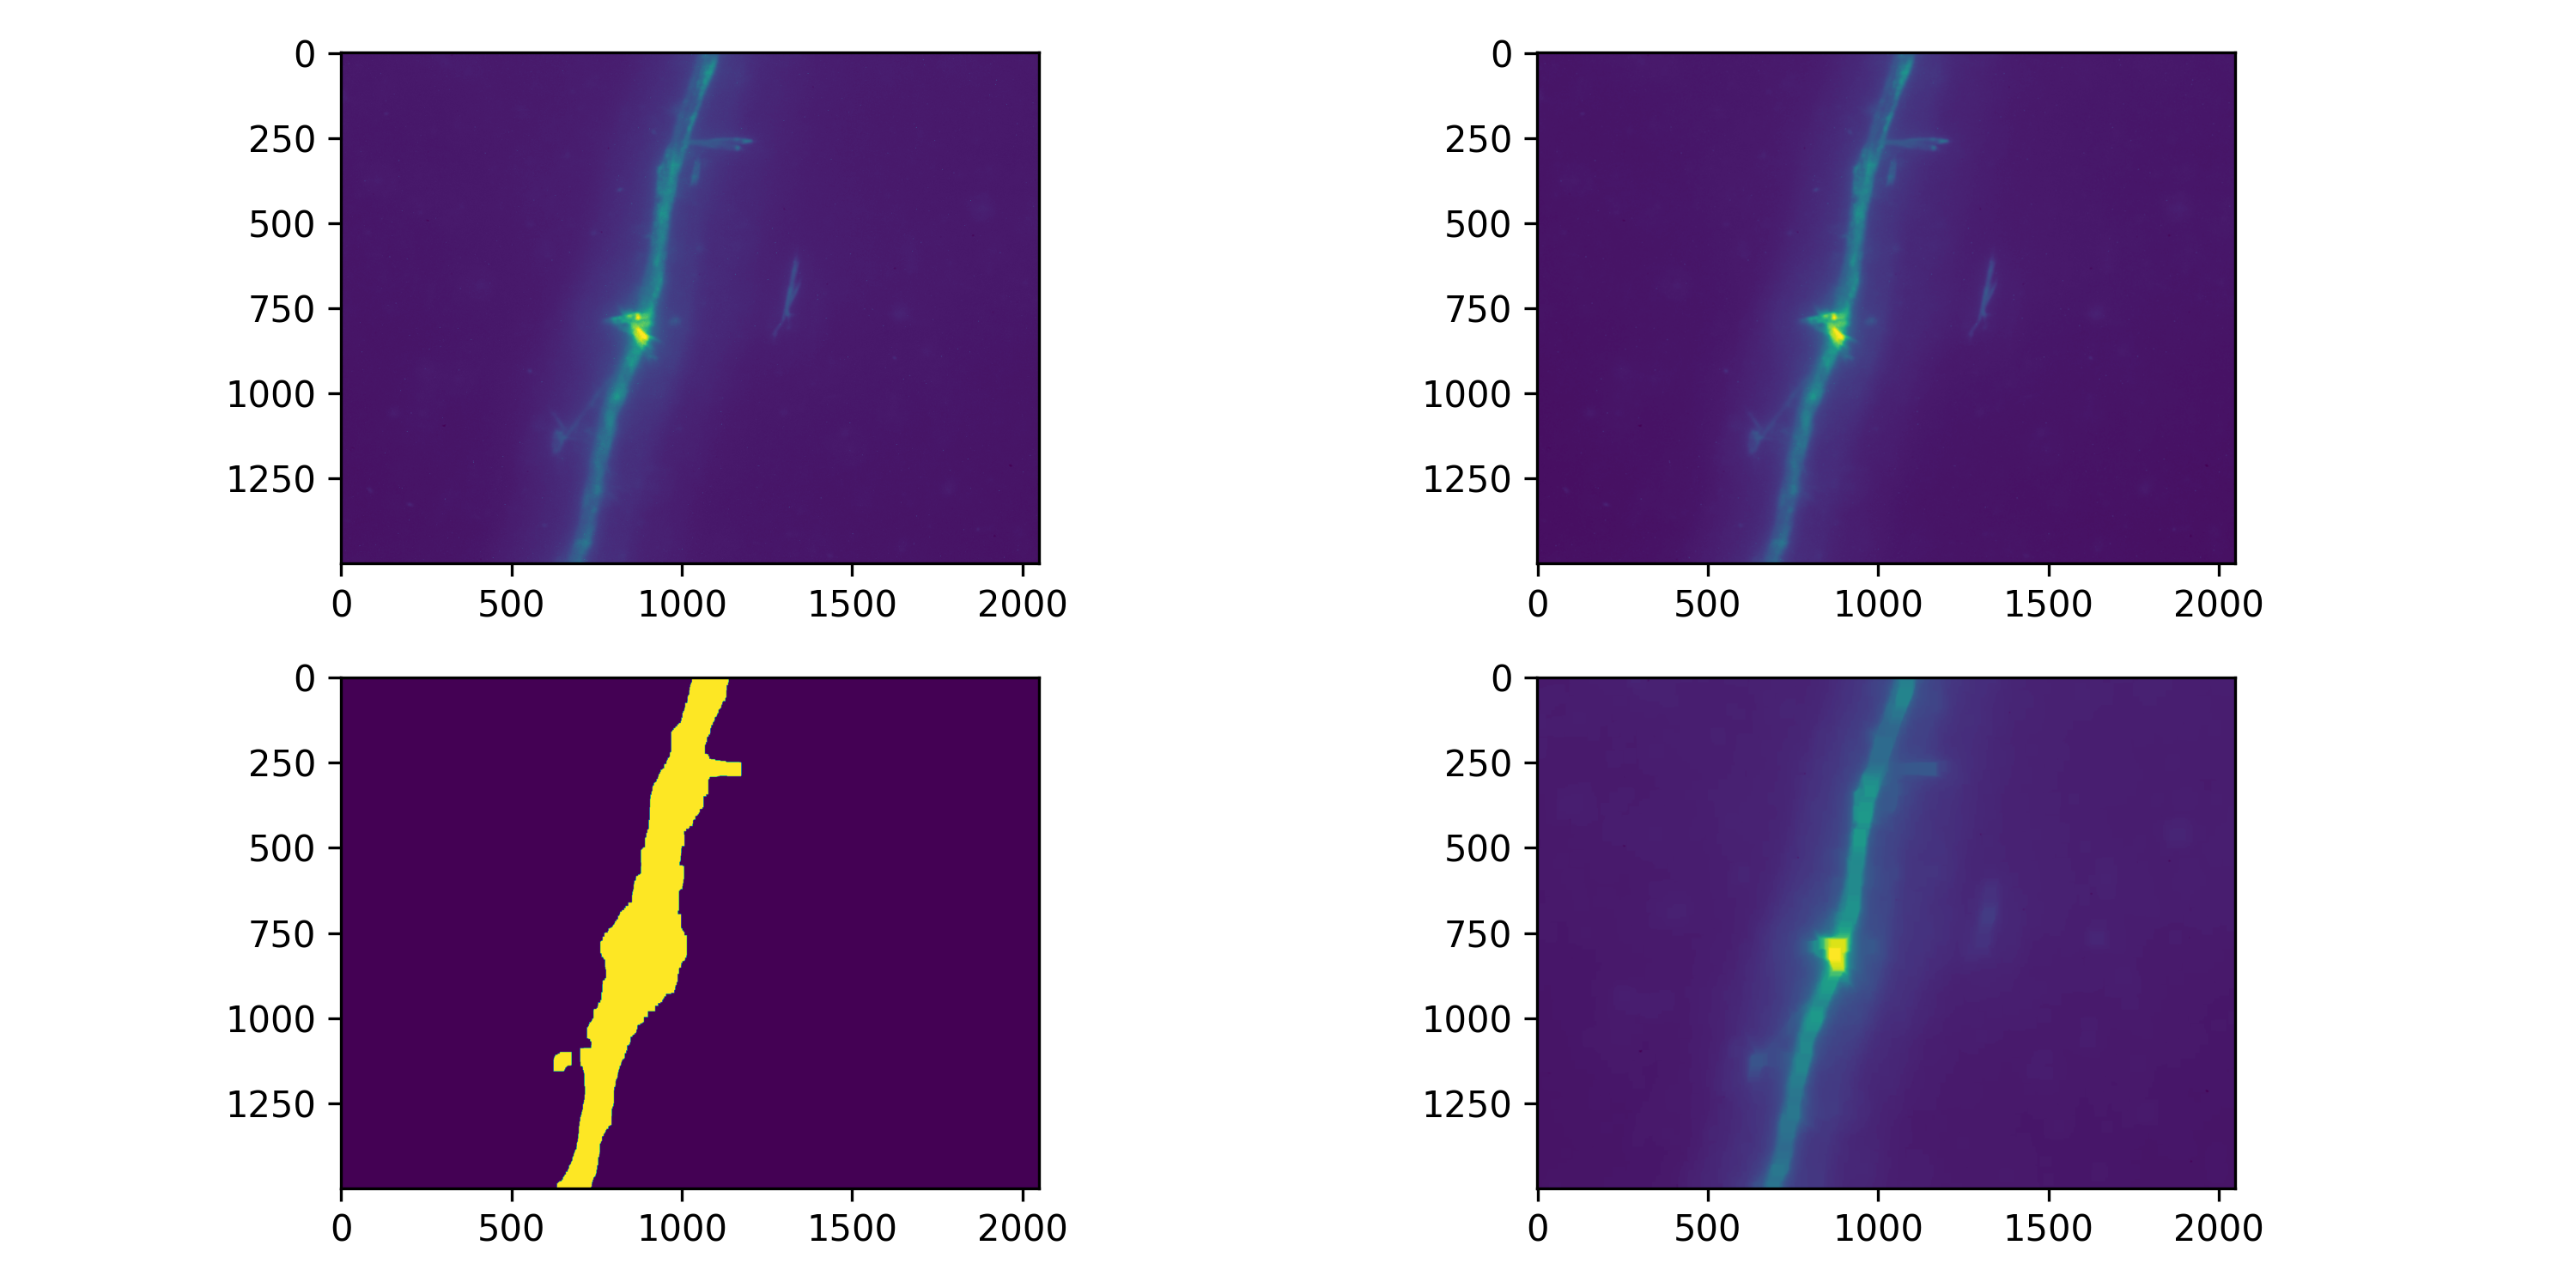

In [19]:
# segmented = segment_brightfield(img, frangi_range = np.arange(5, 40, 3))
# segmented = segment_brightfield(img, frangi_range = np.arange(10, 150, 20))


segmented, segment_alt = segment_fluo(img, magnif=50)
_, segment_thresh = cv2.threshold(
    segment_alt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
segment_thresh = cv2.morphologyEx(segment_thresh, cv2.MORPH_CLOSE, np.ones((9, 9)))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(img)
ax[0][1].imshow(segmented)
ax[1][0].imshow(segment_thresh)
ax[1][1].imshow(segment_alt)
fig.tight_layout()

# fig, ax = plt.subplots()
# ax.hist(segmented.flatten())

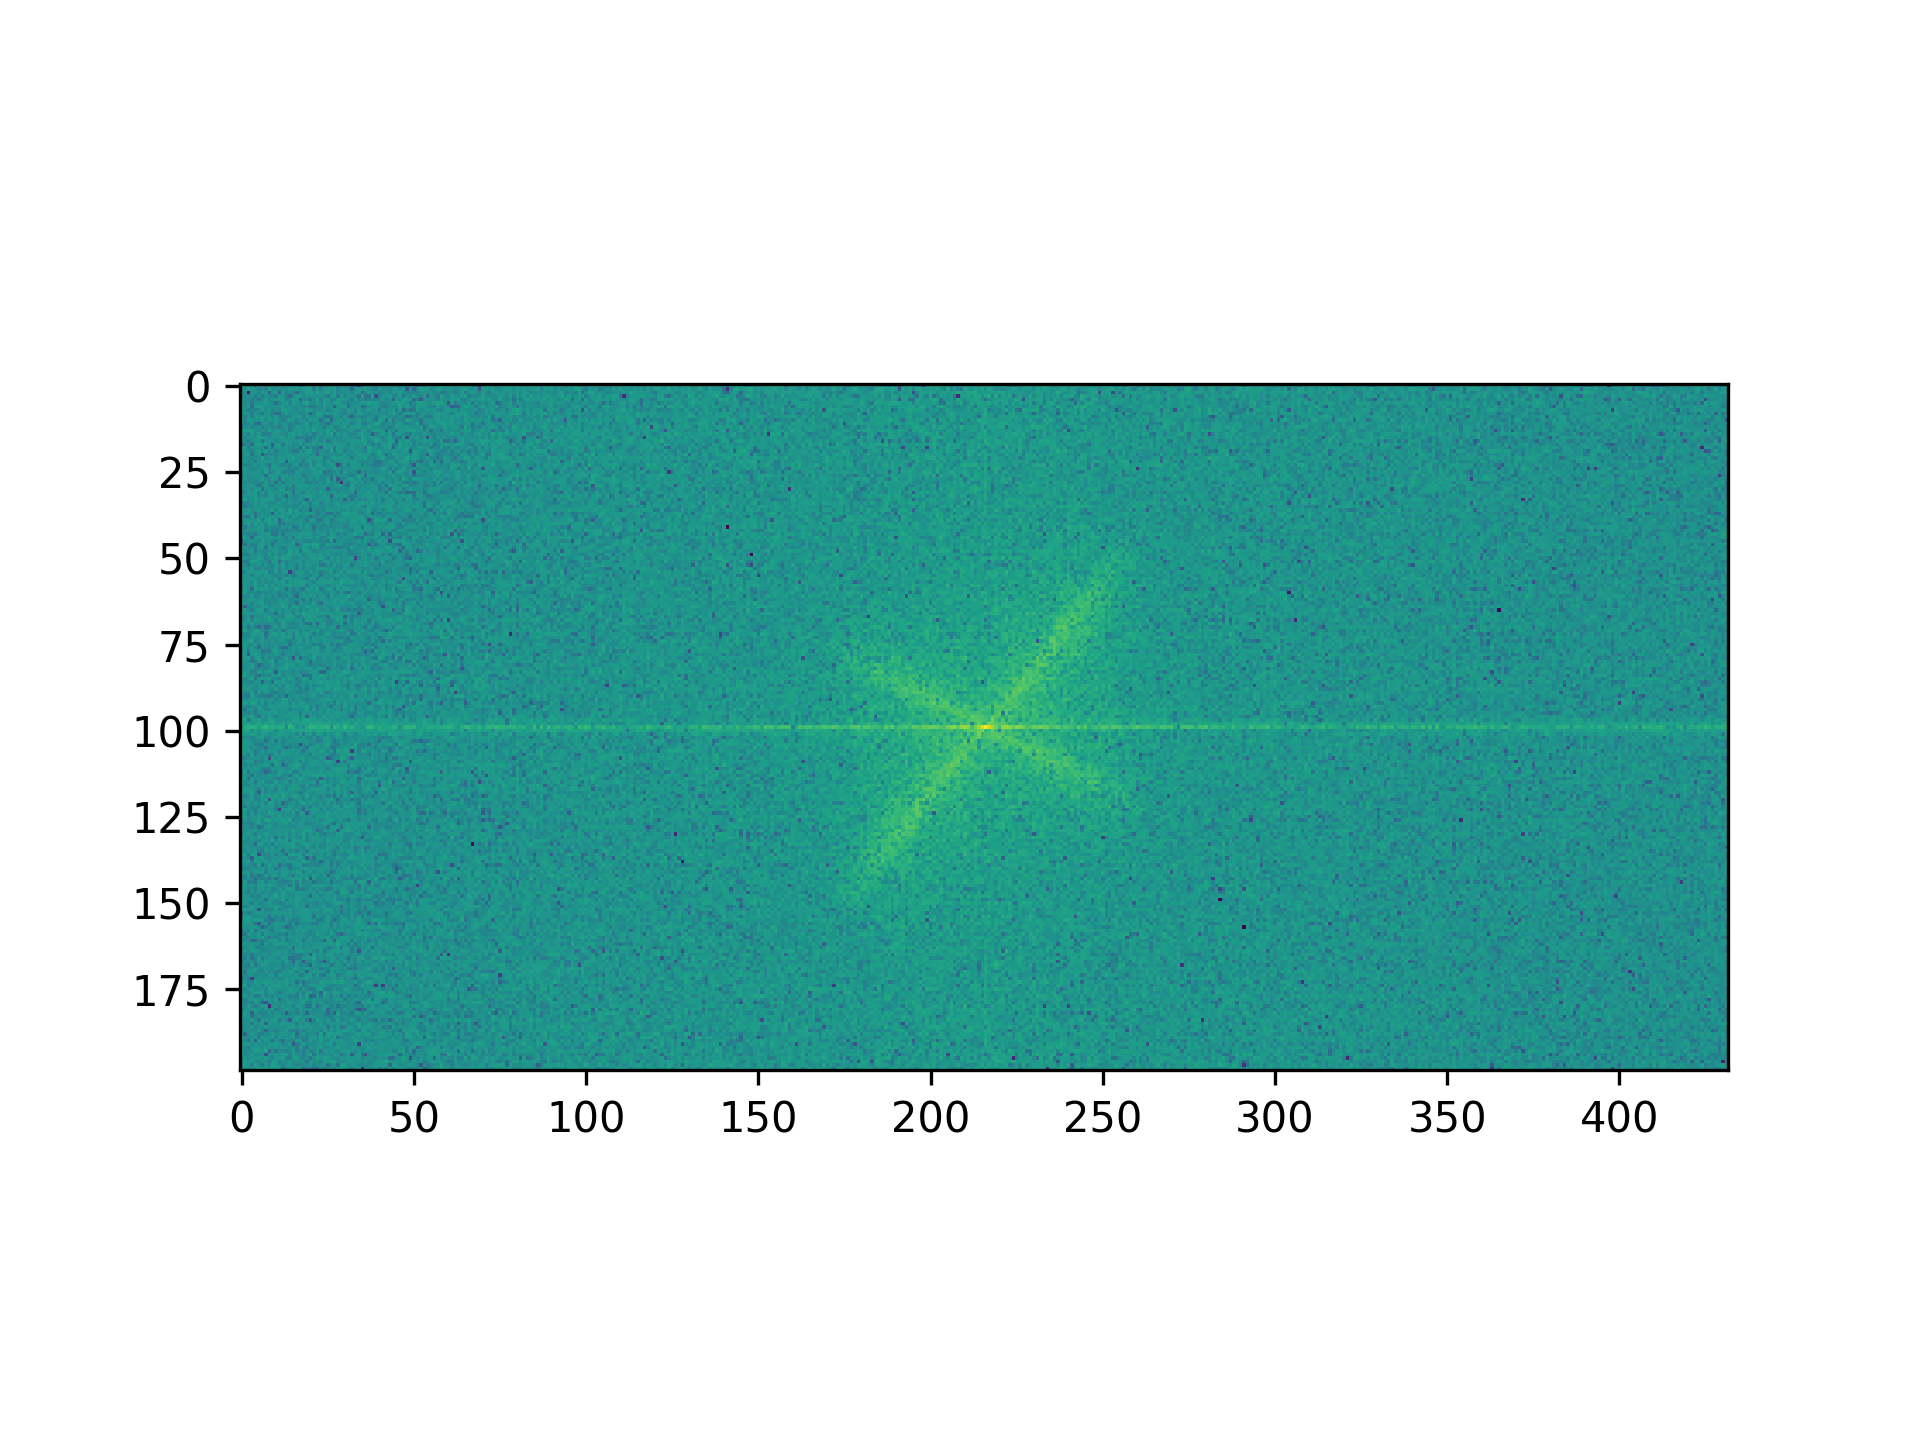

In [13]:
ftimage = np.fft.fft2(img)
ftimage = np.fft.fftshift(ftimage)

fig, ax = plt.subplots()
ax.imshow(np.log(abs(ftimage.real)))